# SpeakUp2.0 EDA and ECG Processing

#### 0. Import Packages 

In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch
import neurokit2 as nk  # toolkits for biosignal processing

### 1. Define key Directories, Variables & Functions 

In [11]:
## PATHS ##
input_PLUX = r'Z:\Davide_MultimodalLab\2_PREPROCESSING\1_XDF_PROCESSING\data_processed_final\marker_3pairs'
output_ECG = r'Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\5_PHYSIOLOGY\ECG_ouput'
output_ECG_figures = r'Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\5_PHYSIOLOGY\ECG_figures'
output_EDA = r'Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\5_PHYSIOLOGY\EDA_output'
output_EDA_figures = r'Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\5_PHYSIOLOGY\EDA_figures'

figures_results = r'Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\5_PHYSIOLOGY\figures_results'
summary_results = r'Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\5_PHYSIOLOGY\summary_results'

print('input_PLUX:', input_PLUX)
print('output_ECG:', output_ECG)
print('output_ECG_figures:', output_ECG_figures)
print('output_EDA:', output_EDA)
print('output_EDA_figures:', output_EDA_figures)


## FUNCTIONS ##

# Function to apply a lowpass Butterworth filter to data using filtfilt (zero-phase filtering)
def butter_lowpass_filter(data, cutoff, fs, order=2):
    """
    Designs and applies a lowpass Butterworth filter to the given data using zero-phase filtering.

    Parameters:
    - data (array-like): The input signal to be filtered.
    - cutoff (float): The cutoff frequency in Hz.
    - fs (float): The sampling frequency in Hz.
    - order (int, optional): The order of the filter. Default is 2.

    Returns:
    - y (array-like): The filtered signal.
    """
    if fs <= 0 or cutoff <= 0:
        raise ValueError("Sampling frequency and cutoff frequency must be positive values.")
    if fs <= 2 * cutoff:
        raise ValueError("Sampling frequency must be greater than twice the cutoff frequency to avoid aliasing.")

    nyquist = 0.5 * fs  # Nyquist frequency is half the sampling rate
    normal_cutoff = cutoff / nyquist  # Normalize the cutoff frequency
    b, a = butter(order, normal_cutoff, btype='low')  # Create a lowpass Butterworth filter
    y = filtfilt(b, a, data)  # Apply filter using filtfilt to get zero-phase filtering (i.e., no phase shift)
    return y
print("butter_lowpass_filter function defined successfully")

# Define Butterworth filter function
def butter_filter(data, cutoff, fs, order=4, filter_type='low'):
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype=filter_type, analog=False)
    # Apply zero-phase filtering with padding to prevent edge effects
    padded_data = np.pad(data, (1000, 1000), 'edge')
    filtered_data = filtfilt(b, a, padded_data)
    return filtered_data[1000:-1000]  # Remove padding


# Define the notch filter function to remove powerline interference
def notch_filter(signal, fs, notch_freq=50, quality_factor=30):
    b, a = iirnotch(notch_freq / (fs / 2), quality_factor)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# Updated ECG processing function with notch filter
def process_ecg(ecg_signal, fs, cutoff_high, cutoff_low, notch_freq, quality_factor):
    # Apply high-pass filter
    high_passed = butter_filter(ecg_signal, cutoff_high, fs, order=4, filter_type='high')
    # Apply low-pass filter
    low_passed = butter_filter(high_passed, cutoff_low, fs, order=4, filter_type='low')
    # Apply notch filter
    filtered = notch_filter(low_passed, fs, notch_freq, quality_factor)
    return filtered



## VARIABLES ##
keyword = 'PLUX'  # keyword to search for in the filename

sampling_rate = 1000  # sampling rate of the signal (Hz)



input_PLUX: Z:\Davide_MultimodalLab\2_PREPROCESSING\1_XDF_PROCESSING\data_processed_final\marker_3pairs
output_ECG: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\5_PHYSIOLOGY\ECG_ouput
output_ECG_figures: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\5_PHYSIOLOGY\ECG_figures
output_EDA: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\5_PHYSIOLOGY\EDA_output
output_EDA_figures: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\5_PHYSIOLOGY\EDA_figures
butter_lowpass_filter function defined successfully


### 2. Process the ECG and EDA Signals in Loop 

In [ ]:
for root, dirs, files in os.walk(input_PLUX):  # Loop through all files in the input directory
   
    for file in files:  # Loop through all files in the input directory
       
        if keyword in file and file.endswith(".csv"):  # Check if the file contains the keyword and is a .csv file
            
            # Extract relevant key words from file name to match later with cloud export folder
            fnam = os.path.basename(file)[:-4]  # Extract the file name and remove the '.csv' extension
            participant_num = '_'.join(fnam.split('_')[0:2])  # Extract participant number from file name
            day_num = fnam.split('_')[2]  # Extract the day number from file name
            condition = '_'.join(fnam.split('_')[6:])  # Extract the condition from the file name
            
            file_path = os.path.join(root, file)
            
            print("Processing file: ", os.path.basename(file_path))
            
            data = pd.read_csv(file_path)  # Read the CSV file
            
            ECG_signal = data['PLUX_ECG1']  # Extract the ECG signal from the CSV file
            
            ### -------------------- ECG --------------------- ###
            print("Processing ECG signal...")

            # Preprocess the ECG signal manually using bandpass and notch filter
            ECG_processed = process_ecg(ECG_signal, sampling_rate, 1, 40, 50, 30)  # 0.5 Hz high-pass, 40 Hz low-pass, 50 Hz notch, 30 Q-factor

            # # Ensure that the z-scores are calculated based on the processed signal
            # z_scores = (ECG_processed - np.mean(ECG_processed)) / np.std(ECG_processed)

            # # Detect and remove segments with large artifacts (replace with NaN)
            # z_score_threshold = 7  # Set a threshold for z-scores
            # ECG_processed_with_nan = ECG_processed.copy()  # Make a copy of the processed ECG
            # ECG_processed_with_nan[np.abs(z_scores) > z_score_threshold] = np.nan  # Replace artifacts with NaN

            # Now, detect R-peaks using nk.ecg_peaks() on the cleaned ECG signal with NaNs
            ecg_peaks, r_peak_info = nk.ecg_peaks(ECG_processed, sampling_rate=sampling_rate, method='neurokit', correct_artifacts=True)

            # Continue with R-peaks detection and heart rate calculation
            r_peaks_indices = np.where(ecg_peaks['ECG_R_Peaks'] == 1)[0]
            r_peak_times_in_seconds = r_peaks_indices / sampling_rate

            # Calculate heart rate
            heart_rate = nk.ecg_rate(r_peaks_indices, sampling_rate=sampling_rate, desired_length=len(ECG_processed))

            # Define the acceptable heart rate range
            min_hr = 70
            max_hr = 145

            # Detect heart rate values that fall outside the range
            out_of_range_mask = (heart_rate < min_hr) | (heart_rate > max_hr)

            # Smooth out the outliers using interpolation
            # Interpolate only the outlier values, while leaving the in-range values as they are
            heart_rate_smoothed = pd.Series(heart_rate).copy()  # Copy to preserve original heart rate

            # Apply interpolation to smooth the outliers
            heart_rate_smoothed[out_of_range_mask] = np.interp(
                np.where(out_of_range_mask)[0],  # Positions of outliers
                np.where(~out_of_range_mask)[0],  # Positions of valid heart rate values
                heart_rate[~out_of_range_mask]    # Valid heart rate values
            )

            # Now clamp the smoothed values to ensure they fall within the specified range
            heart_rate_clamped = np.clip(heart_rate_smoothed, min_hr, max_hr)



            # Compute HRV metrics (time and frequency domain)
            hrv_time = nk.hrv_time(ecg_peaks, sampling_rate=sampling_rate)
            hrv_freq = nk.hrv_frequency(ecg_peaks, sampling_rate=sampling_rate)

            # Extract MeanNN and SDNN from the HRV time data
            mean_nn = hrv_time['HRV_MeanNN'].values[0]
            sdnn = hrv_time['HRV_SDNN'].values[0]

            # Create a data matrix with all this info
            ECG_matrix = pd.DataFrame({
                'LSL_Time': data['LSL_Time'],
                'Time (s)': (data['LSL_Time'] - data['LSL_Time'].iloc[0]),  # Convert LSL time to seconds
                'raw_ECG': ECG_signal,
                'filtered_ECG': ECG_processed,  # The cleaned ECG with NaNs where artifacts were
                'heart_rate': heart_rate,
                'HRV_mean_nn': pd.Series([mean_nn] * len(data), index=data.index),
                'HRV_sdnn': pd.Series([sdnn] * len(data), index=data.index)
            })
                    
            ## Save the ECG data matrix to a CSV file
            print("Saving ECG data matrix to CSV file...")
            outputfilename = os.path.join(output_ECG, f'{participant_num}_{day_num}_{condition}_ECG_processed.csv')
            outputfilepath = os.path.join(output_ECG, outputfilename)
            ECG_matrix.to_csv(outputfilepath, index=False)

            ### PLOT ECG SIGNALS ###

            # Set figure size for larger plots
            plt.figure(figsize=(16, 20))

            # Select the first 10 seconds of data for plotting
            ten_seconds_data_ecg = ECG_matrix[ECG_matrix['Time (s)'] <= 10]
            r_peaks_in_10s = r_peak_times_in_seconds[r_peak_times_in_seconds <= 10]

            # 1. Raw and Filtered ECG Signal (Full)
            plt.subplot(5, 1, 1)
            plt.plot(ECG_matrix['Time (s)'], ECG_signal, label='ECG (Raw)', color='blue', lw=0.5, alpha=0.7)
            plt.plot(ECG_matrix['Time (s)'], ECG_processed, label='ECG (Filtered)', lw=1, color='red')
            plt.legend()
            plt.xlabel('Time (s)')
            plt.title('Raw and Filtered ECG Signal (Full Duration)')

            # 2. Raw and Filtered ECG Signal (First 10 seconds)
            plt.subplot(5, 1, 2)
            plt.plot(ten_seconds_data_ecg['Time (s)'], ten_seconds_data_ecg['raw_ECG'], label='ECG (Raw) - 10 seconds', color='blue', lw=0.5, alpha=0.7)
            plt.plot(ten_seconds_data_ecg['Time (s)'], ten_seconds_data_ecg['filtered_ECG'], label='ECG (Filtered) - 10 seconds', lw=1, color='red')
            plt.legend()
            plt.xlabel('Time (s)')
            plt.title('Raw and Filtered ECG Signal (First 10 Seconds)')

            # 3. Filtered ECG Signal with R peaks detected for the first 10 seconds
            plt.subplot(5, 1, 3)
            plt.plot(ten_seconds_data_ecg['Time (s)'], ten_seconds_data_ecg['filtered_ECG'], label='Cleaned ECG', color='red', lw=1)
            # Mark the R-peaks on the plot for the first 10 seconds
            for peak_time in r_peaks_in_10s:
                plt.axvline(x=peak_time, color='green', linestyle='--', lw=2.5, alpha=0.5, label='R-Peak' if peak_time == r_peaks_in_10s[0] else "")
            plt.xlabel('Time (s)')
            plt.ylabel('ECG Amplitude')
            plt.title('ECG Signal with Detected R-Peaks (First 10 Seconds)')
            plt.legend()

            # 4. Heart Rate (Full)
            plt.subplot(5, 1, 4)
            plt.plot(ECG_matrix['Time (s)'], heart_rate, label='Heart Rate', color='magenta', lw=1.5)
            plt.legend()
            plt.xlabel('Time (s)')
            plt.ylabel('Heart Rate (bpm)')
            plt.title('Heart Rate Over Time (Full Duration)')

            # 5. Heart Rate (First 10 seconds)
            plt.subplot(5, 1, 5)
            plt.plot(ten_seconds_data_ecg['Time (s)'], ten_seconds_data_ecg['heart_rate'], label='Heart Rate - 10 seconds', color='magenta', lw=1.5)
            plt.legend()
            plt.xlabel('Time (s)')
            plt.ylabel('Heart Rate (bpm)')
            plt.title('Heart Rate Over First 10 Seconds')

            plt.tight_layout(pad=2.0)

            # Save the ECG figure
            print("Saving ECG figure to PNG file...")
            outputfilename = os.path.join(output_ECG_figures, f'{participant_num}_{day_num}_{condition}_ECG_figure_10_seconds.png')
            plt.savefig(outputfilename, dpi=300)
            plt.show()

            ### -------------------- EDA Processing and Plotting -------------------- ###
            print("Processing EDA signal...")
            EDA_signal = data['PLUX_EDA0']

            # Process the EDA signal
            eda_signals, eda_info = nk.eda_process(EDA_signal, sampling_rate)
            tonic_eda = eda_signals['EDA_Tonic']
            phasic_eda = eda_signals['EDA_Phasic']

            # Create a data matrix for EDA signals
            EDA_matrix = pd.DataFrame({
                'LSL_Time': data['LSL_Time'],
                'Time (s)': (data['LSL_Time'] - data['LSL_Time'].iloc[0]) / 1e9,  # Convert to seconds
                'raw_EDA': EDA_signal,
                'filtered_EDA': eda_signals['EDA_Clean'],
                'tonic_EDA': tonic_eda,
                'phasic_EDA': phasic_eda
            })

            # Save the EDA data matrix to a CSV file
            outputfilename = os.path.join(output_EDA, f'{participant_num}_{day_num}_{condition}_EDA_processed.csv')
            EDA_matrix.to_csv(outputfilename, index=False)

            # Plotting the EDA signals (similar to ECG plotting)
            plt.figure(figsize=(16, 16))
           


### RESULTS PLOTTING. Here I'm plotting the Heart Rate and Tonic EDA for each participant all segments

Processing participant: pilot_01_d2
Found file: pilot_01_d2_speech_lsl_PLUX_Speech_Start_SUD_1_Start.csv
Found file: pilot_01_d2_speech_lsl_PLUX_SUD_1_End_SUD_2_Start.csv
Found file: pilot_01_d2_speech_lsl_PLUX_SUD_2_End_SUD_3_Start.csv
Sorted files: ['Z:\\Davide_MultimodalLab\\2_PREPROCESSING\\1_XDF_PROCESSING\\data_processed_final\\marker_3pairs\\pilot_01\\day2\\pilot_01_d2_speech_lsl_PLUX_Speech_Start_SUD_1_Start.csv', 'Z:\\Davide_MultimodalLab\\2_PREPROCESSING\\1_XDF_PROCESSING\\data_processed_final\\marker_3pairs\\pilot_01\\day2\\pilot_01_d2_speech_lsl_PLUX_SUD_1_End_SUD_2_Start.csv', 'Z:\\Davide_MultimodalLab\\2_PREPROCESSING\\1_XDF_PROCESSING\\data_processed_final\\marker_3pairs\\pilot_01\\day2\\pilot_01_d2_speech_lsl_PLUX_SUD_2_End_SUD_3_Start.csv']
Processing file: pilot_01_d2_speech_lsl_PLUX_Speech_Start_SUD_1_Start.csv
Processing ECG signal...
Processing EDA signal...
Processing file: pilot_01_d2_speech_lsl_PLUX_SUD_1_End_SUD_2_Start.csv
Processing ECG signal...
Processing E

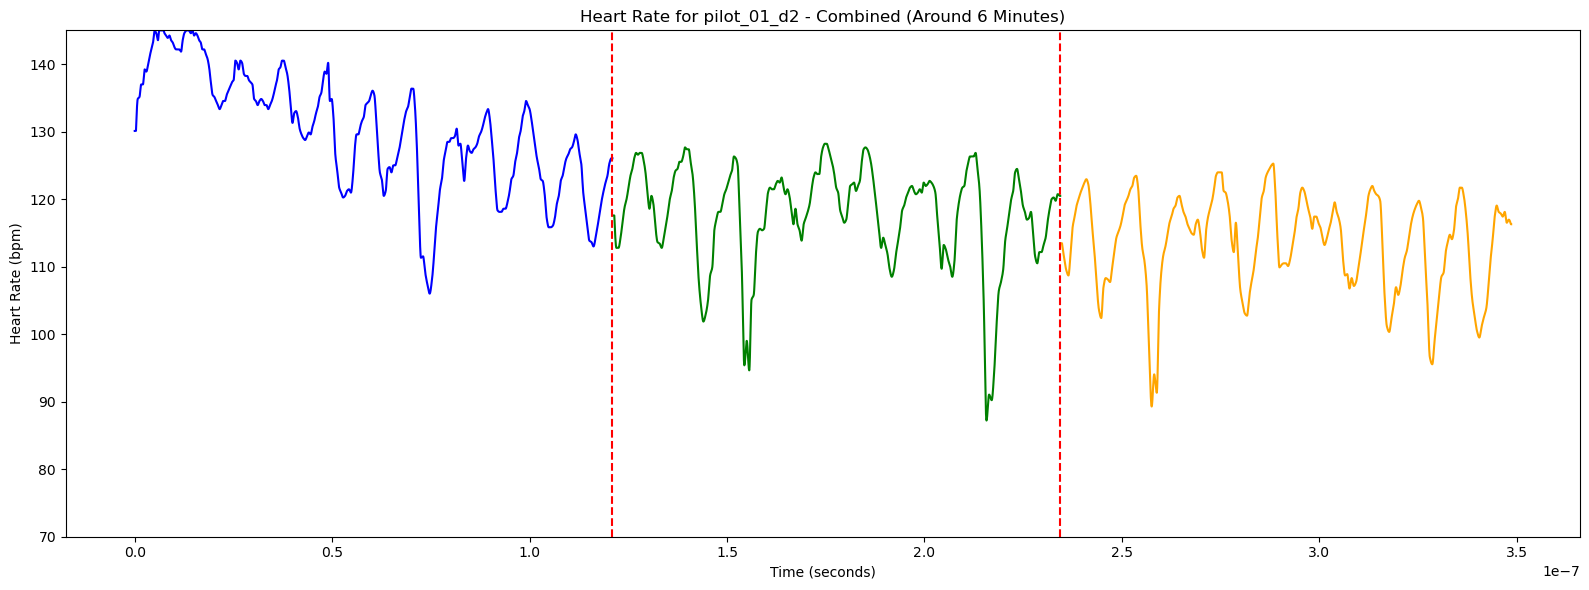

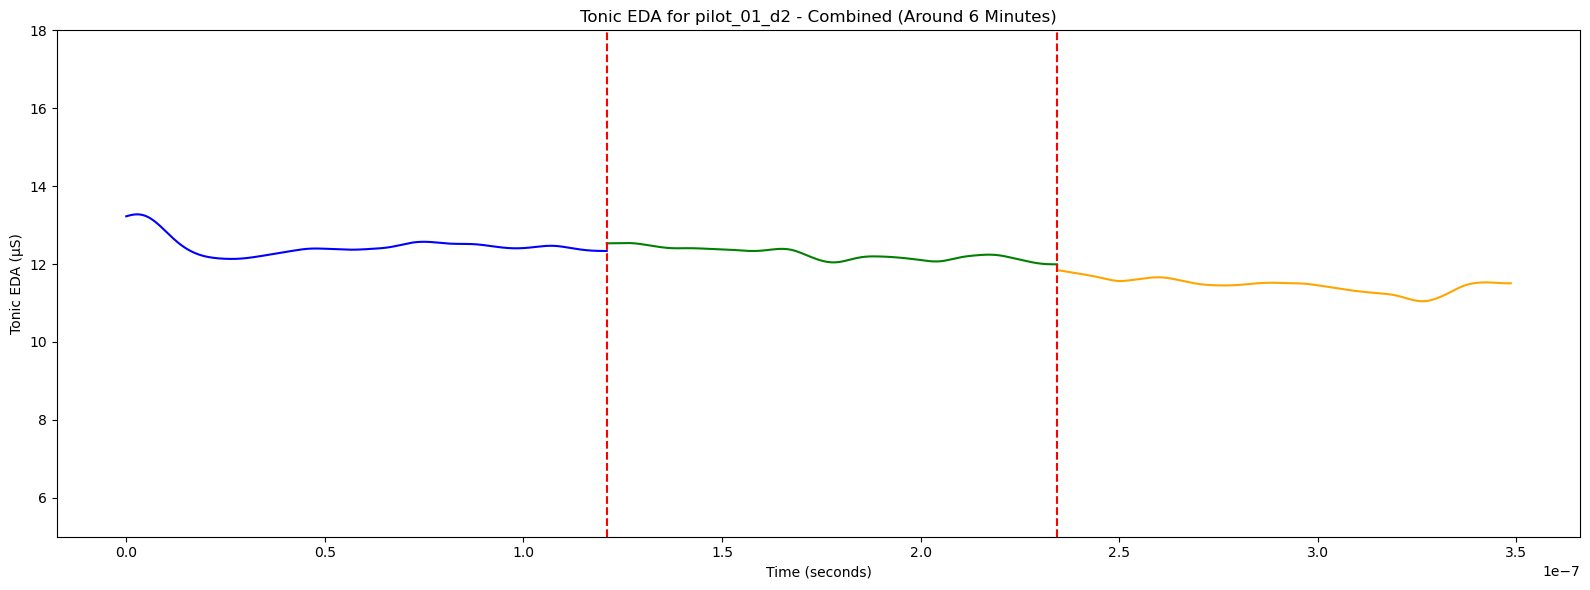

Processing participant: pilot_01_d3
Found file: pilot_01_d3_speech_lsl_PLUX_Speech_Start_SUD_1_Start.csv
Found file: pilot_01_d3_speech_lsl_PLUX_SUD_1_End_SUD_2_Start.csv
Found file: pilot_01_d3_speech_lsl_PLUX_SUD_2_End_SUD_3_Start.csv
Sorted files: ['Z:\\Davide_MultimodalLab\\2_PREPROCESSING\\1_XDF_PROCESSING\\data_processed_final\\marker_3pairs\\pilot_01\\day3\\pilot_01_d3_speech_lsl_PLUX_Speech_Start_SUD_1_Start.csv', 'Z:\\Davide_MultimodalLab\\2_PREPROCESSING\\1_XDF_PROCESSING\\data_processed_final\\marker_3pairs\\pilot_01\\day3\\pilot_01_d3_speech_lsl_PLUX_SUD_1_End_SUD_2_Start.csv', 'Z:\\Davide_MultimodalLab\\2_PREPROCESSING\\1_XDF_PROCESSING\\data_processed_final\\marker_3pairs\\pilot_01\\day3\\pilot_01_d3_speech_lsl_PLUX_SUD_2_End_SUD_3_Start.csv']
Processing file: pilot_01_d3_speech_lsl_PLUX_Speech_Start_SUD_1_Start.csv
Processing ECG signal...
Processing EDA signal...
Processing file: pilot_01_d3_speech_lsl_PLUX_SUD_1_End_SUD_2_Start.csv
Processing ECG signal...
Processing E

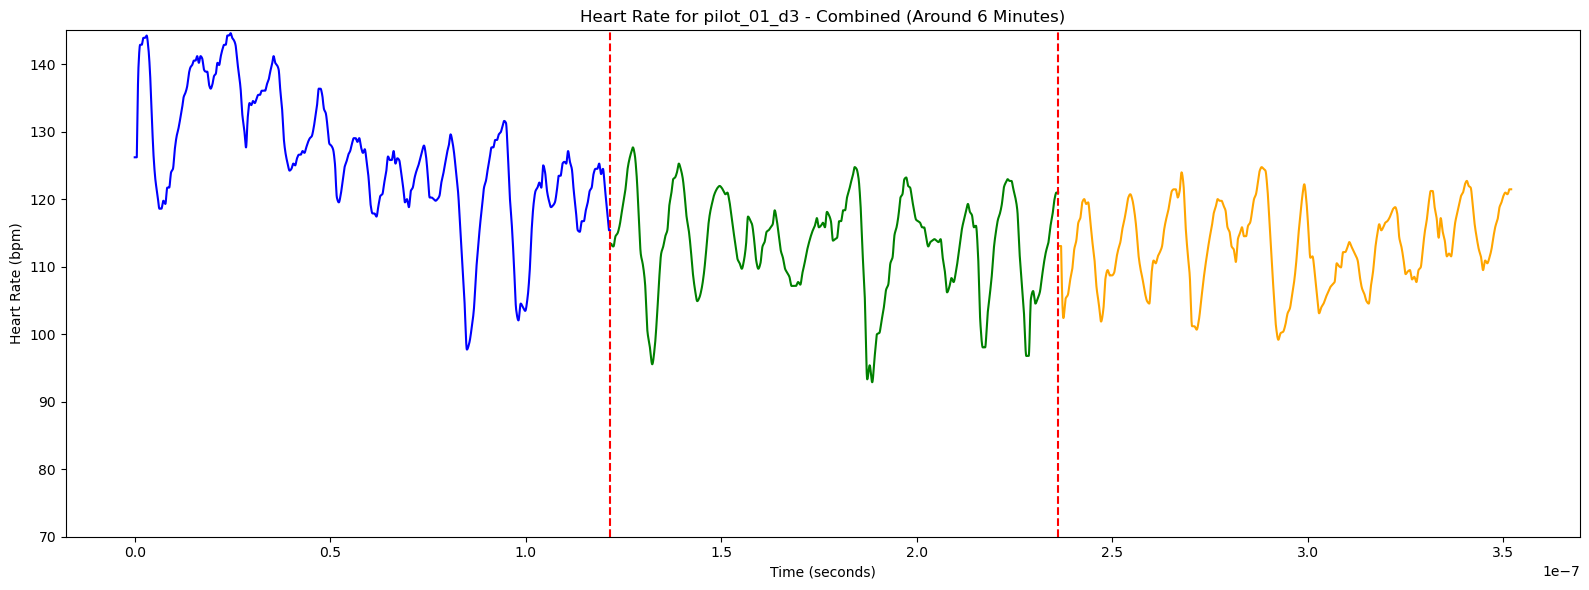

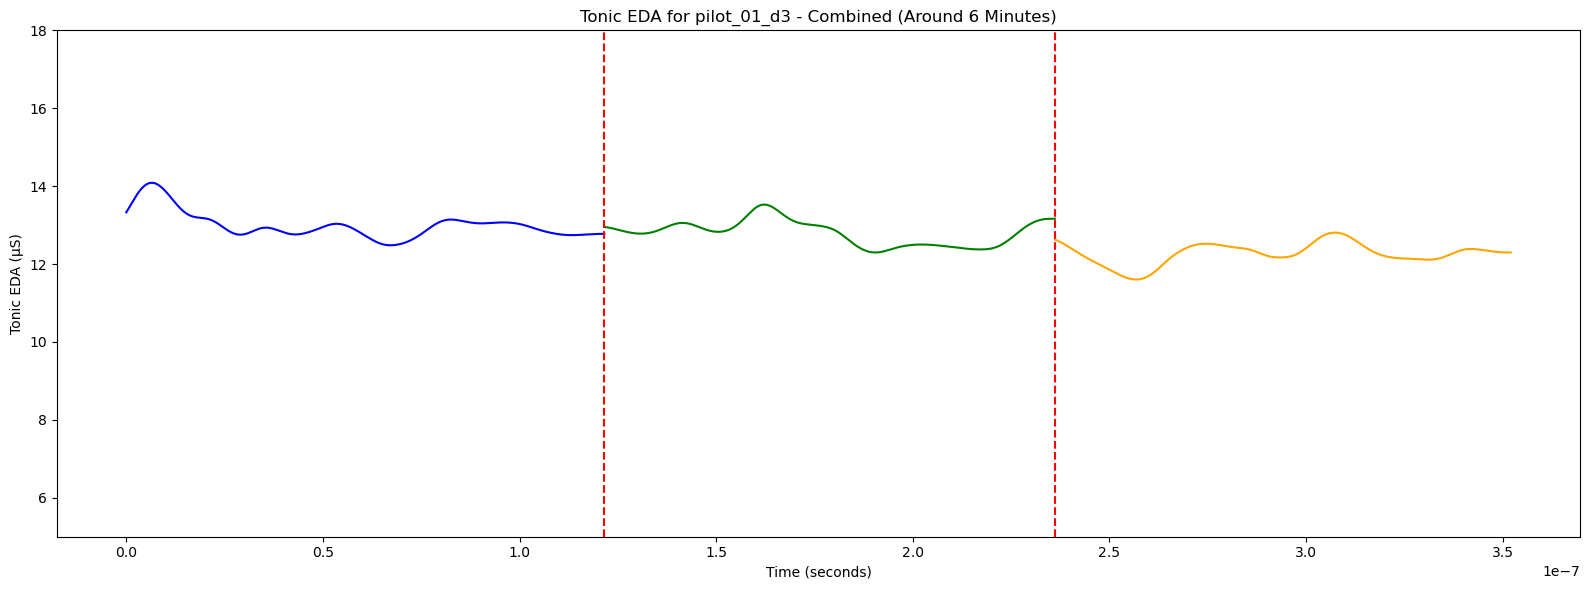

Processing participant: pilot_02_d2
Found file: pilot_02_d2_speech_lsl_PLUX_Speech_Start_SUD_1_Start.csv
Found file: pilot_02_d2_speech_lsl_PLUX_SUD_1_End_SUD_2_Start.csv
Found file: pilot_02_d2_speech_lsl_PLUX_SUD_2_End_SUD_3_Start.csv
Sorted files: ['Z:\\Davide_MultimodalLab\\2_PREPROCESSING\\1_XDF_PROCESSING\\data_processed_final\\marker_3pairs\\pilot_02\\day2\\pilot_02_d2_speech_lsl_PLUX_Speech_Start_SUD_1_Start.csv', 'Z:\\Davide_MultimodalLab\\2_PREPROCESSING\\1_XDF_PROCESSING\\data_processed_final\\marker_3pairs\\pilot_02\\day2\\pilot_02_d2_speech_lsl_PLUX_SUD_1_End_SUD_2_Start.csv', 'Z:\\Davide_MultimodalLab\\2_PREPROCESSING\\1_XDF_PROCESSING\\data_processed_final\\marker_3pairs\\pilot_02\\day2\\pilot_02_d2_speech_lsl_PLUX_SUD_2_End_SUD_3_Start.csv']
Processing file: pilot_02_d2_speech_lsl_PLUX_Speech_Start_SUD_1_Start.csv
Processing ECG signal...
Processing EDA signal...
Processing file: pilot_02_d2_speech_lsl_PLUX_SUD_1_End_SUD_2_Start.csv
Processing ECG signal...
Processing E

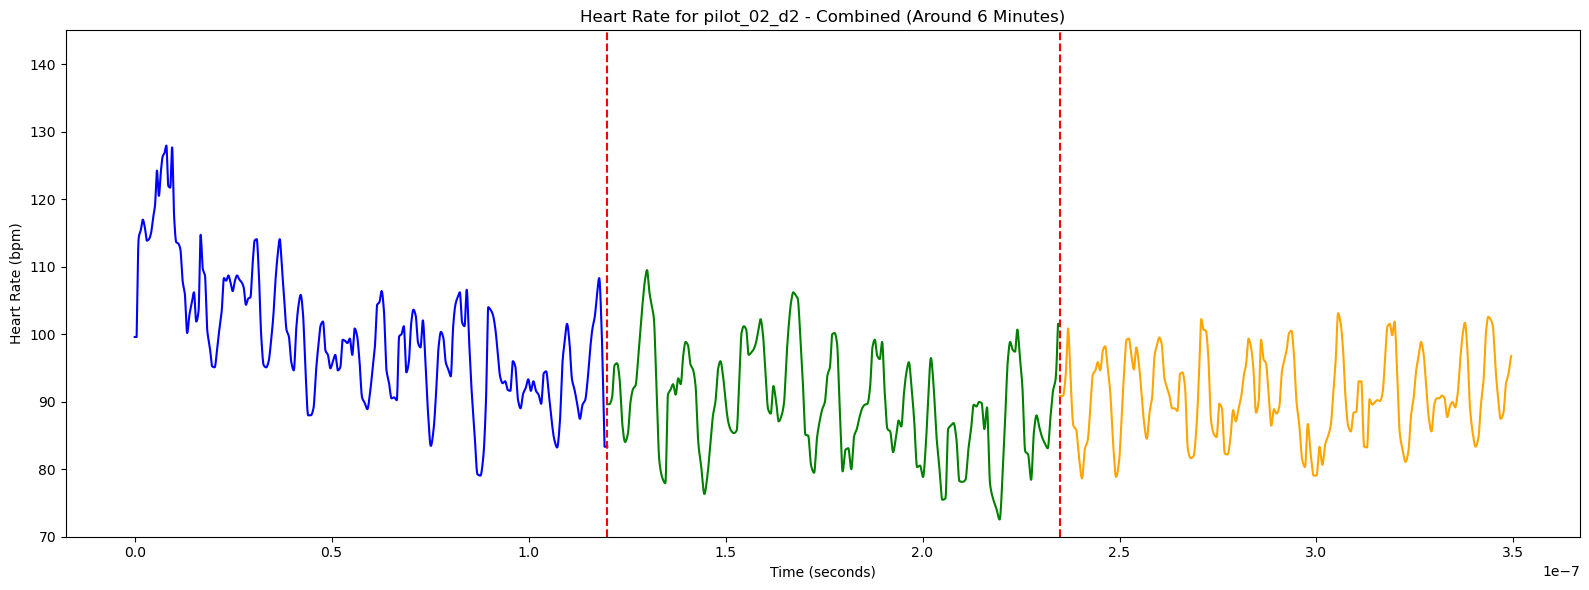

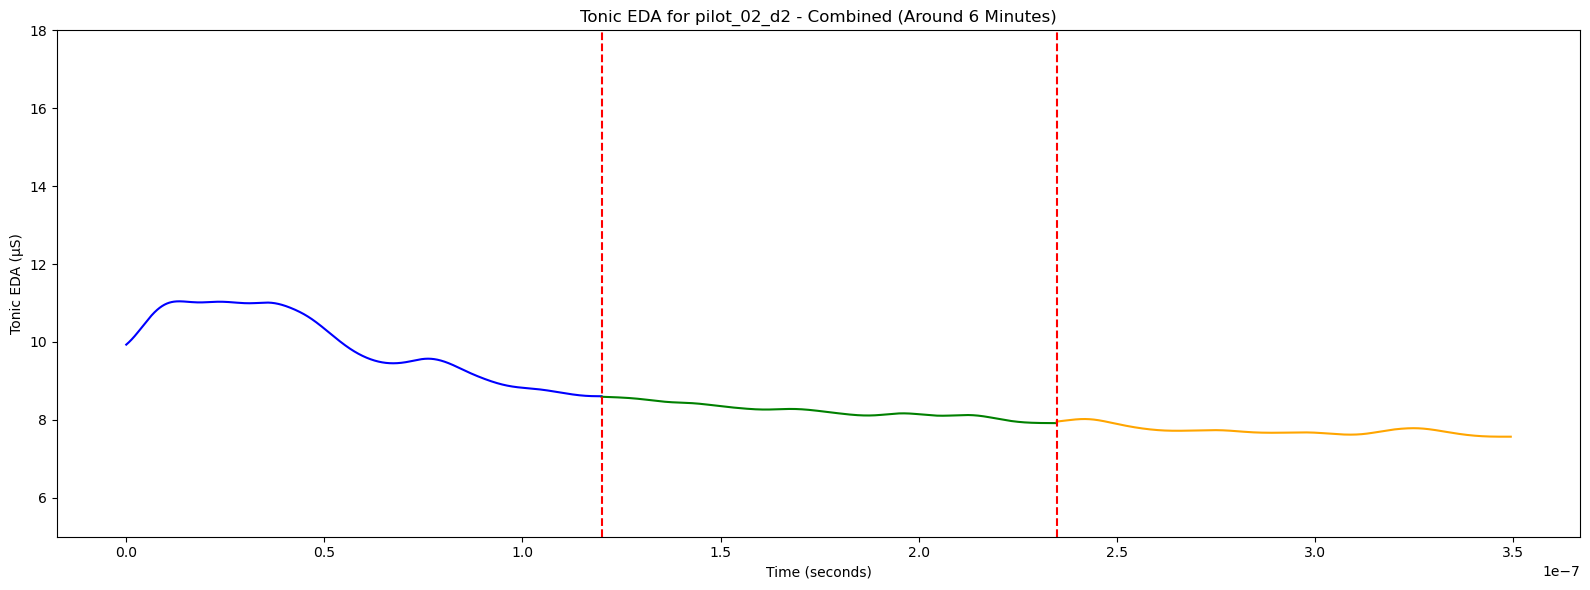

Processing participant: pilot_02_d3
Found file: pilot_02_d3_speech_lsl_PLUX_Speech_Start_SUD_1_Start.csv
Found file: pilot_02_d3_speech_lsl_PLUX_SUD_1_End_SUD_2_Start.csv
Found file: pilot_02_d3_speech_lsl_PLUX_SUD_2_End_SUD_3_Start.csv
Sorted files: ['Z:\\Davide_MultimodalLab\\2_PREPROCESSING\\1_XDF_PROCESSING\\data_processed_final\\marker_3pairs\\pilot_02\\day3\\pilot_02_d3_speech_lsl_PLUX_Speech_Start_SUD_1_Start.csv', 'Z:\\Davide_MultimodalLab\\2_PREPROCESSING\\1_XDF_PROCESSING\\data_processed_final\\marker_3pairs\\pilot_02\\day3\\pilot_02_d3_speech_lsl_PLUX_SUD_1_End_SUD_2_Start.csv', 'Z:\\Davide_MultimodalLab\\2_PREPROCESSING\\1_XDF_PROCESSING\\data_processed_final\\marker_3pairs\\pilot_02\\day3\\pilot_02_d3_speech_lsl_PLUX_SUD_2_End_SUD_3_Start.csv']
Processing file: pilot_02_d3_speech_lsl_PLUX_Speech_Start_SUD_1_Start.csv
Processing ECG signal...
Processing EDA signal...
Processing file: pilot_02_d3_speech_lsl_PLUX_SUD_1_End_SUD_2_Start.csv
Processing ECG signal...
Processing E

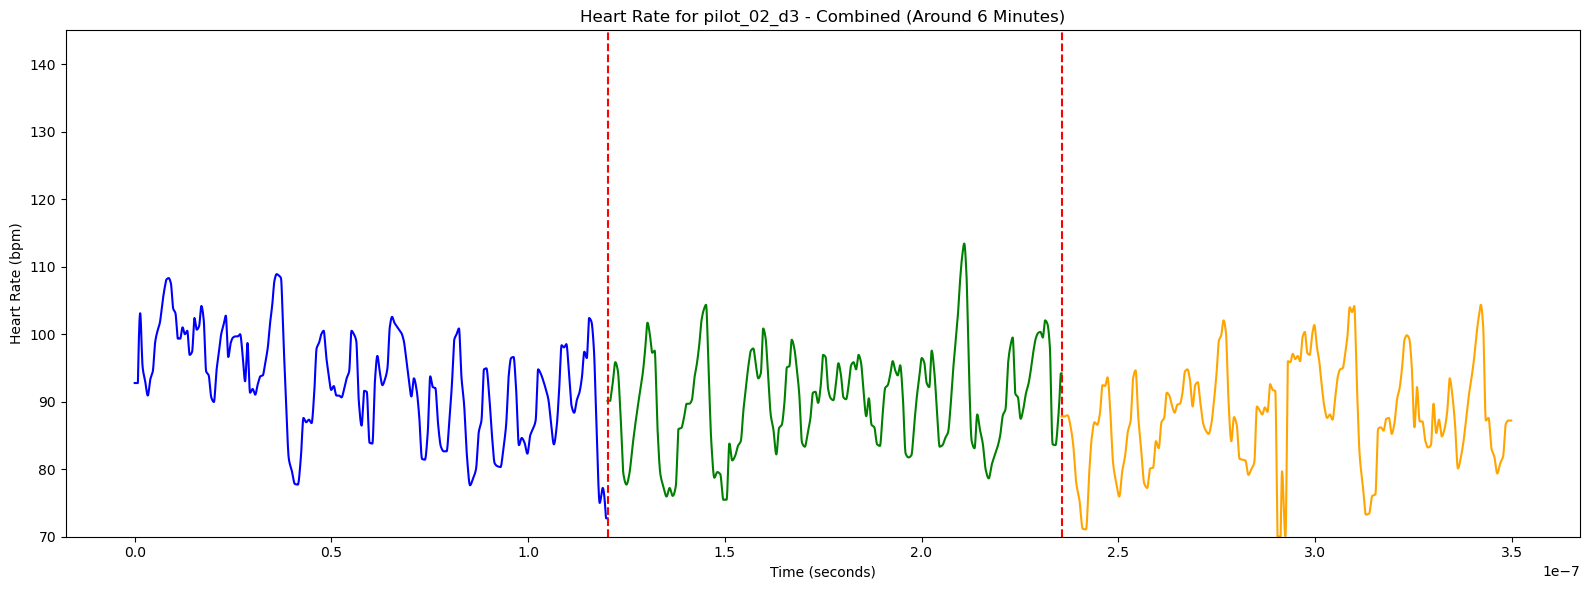

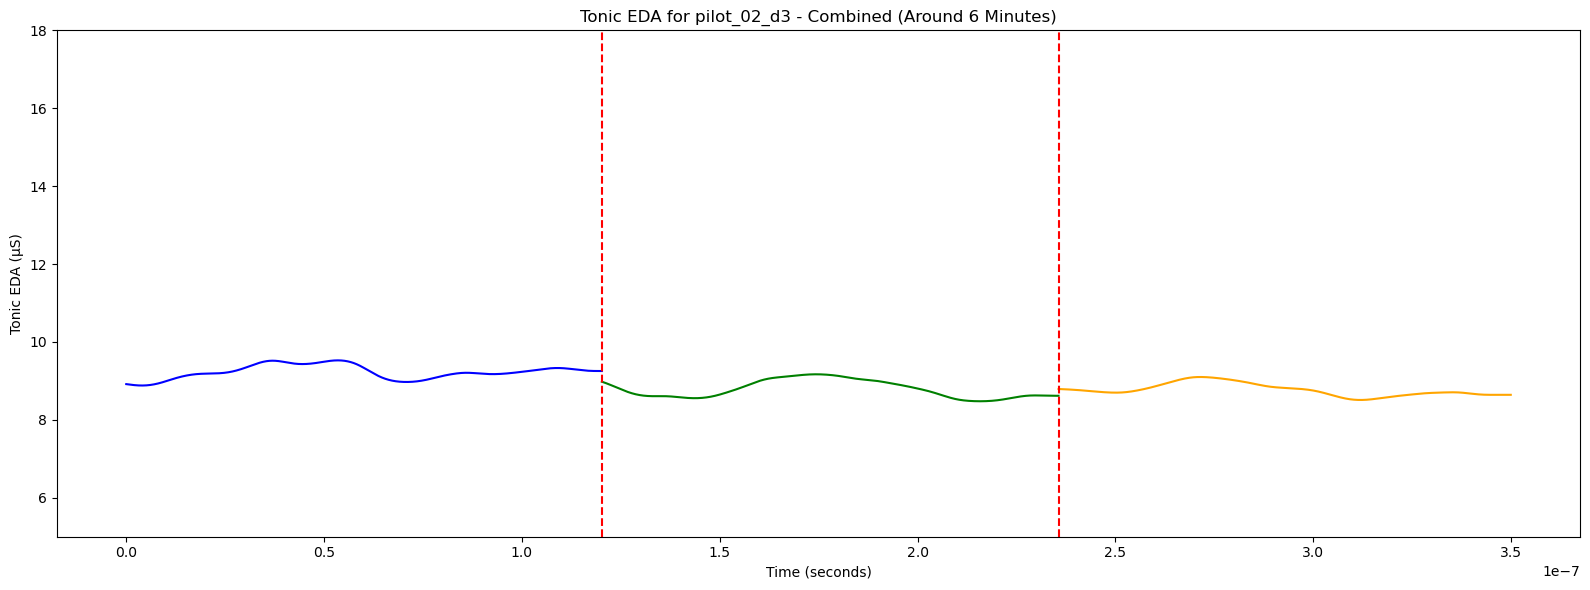

Processing participant: pilot_04_d2
Found file: pilot_04_d2_speech_lsl_PLUX_Speech_Start_SUD_1_Start.csv
Found file: pilot_04_d2_speech_lsl_PLUX_SUD_1_End_SUD_2_Start.csv
Found file: pilot_04_d2_speech_lsl_PLUX_SUD_2_End_SUD_3_Start.csv
Sorted files: ['Z:\\Davide_MultimodalLab\\2_PREPROCESSING\\1_XDF_PROCESSING\\data_processed_final\\marker_3pairs\\pilot_04\\day2\\pilot_04_d2_speech_lsl_PLUX_Speech_Start_SUD_1_Start.csv', 'Z:\\Davide_MultimodalLab\\2_PREPROCESSING\\1_XDF_PROCESSING\\data_processed_final\\marker_3pairs\\pilot_04\\day2\\pilot_04_d2_speech_lsl_PLUX_SUD_1_End_SUD_2_Start.csv', 'Z:\\Davide_MultimodalLab\\2_PREPROCESSING\\1_XDF_PROCESSING\\data_processed_final\\marker_3pairs\\pilot_04\\day2\\pilot_04_d2_speech_lsl_PLUX_SUD_2_End_SUD_3_Start.csv']
Processing file: pilot_04_d2_speech_lsl_PLUX_Speech_Start_SUD_1_Start.csv
Processing ECG signal...
Processing EDA signal...
Processing file: pilot_04_d2_speech_lsl_PLUX_SUD_1_End_SUD_2_Start.csv
Processing ECG signal...
Processing E

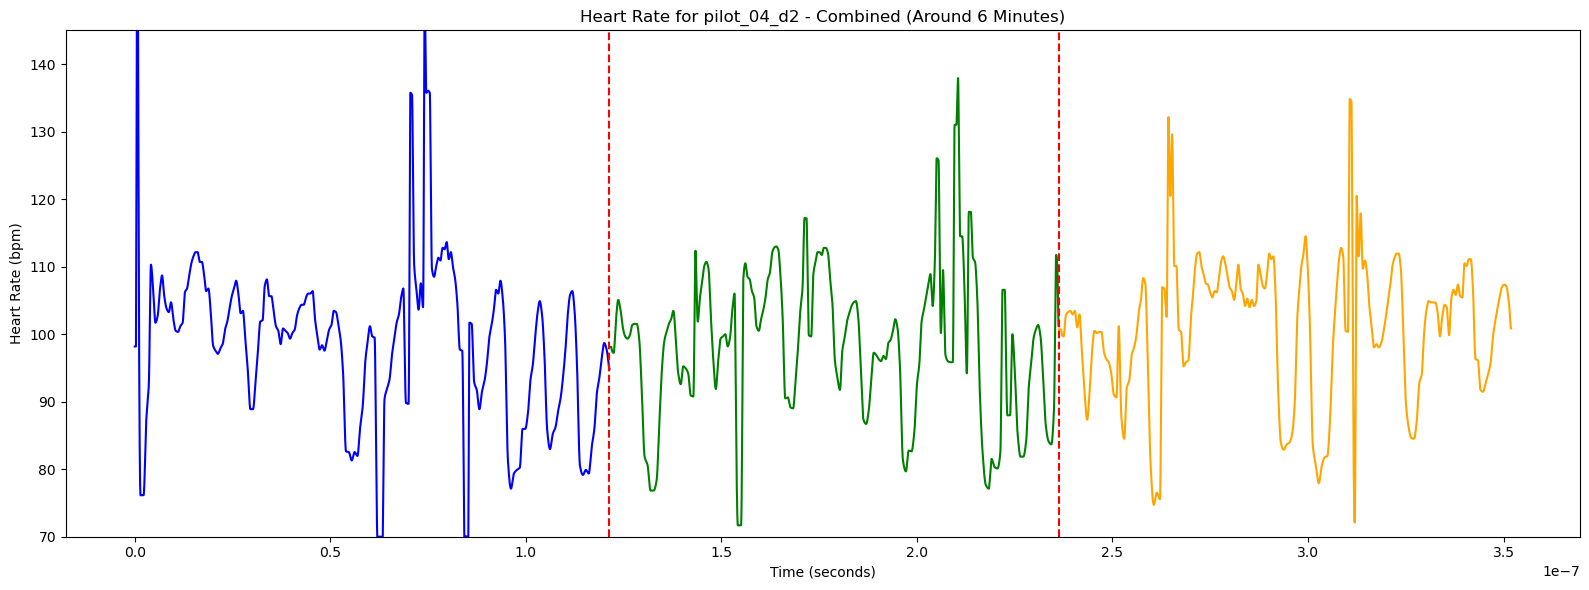

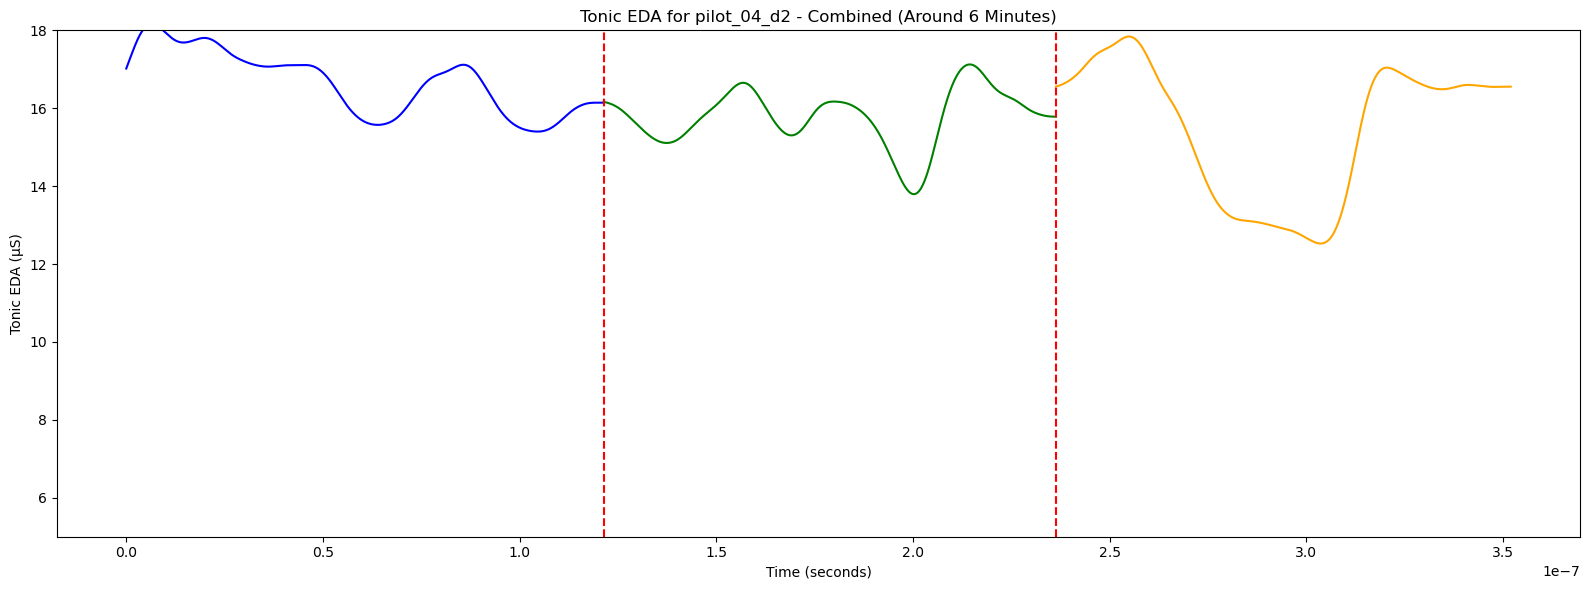

Processing participant: pilot_05_d2
Found file: pilot_05_d2_speech_lsl_PLUX_Speech_Start_SUD_1_Start.csv
Found file: pilot_05_d2_speech_lsl_PLUX_SUD_1_End_SUD_2_Start.csv
Found file: pilot_05_d2_speech_lsl_PLUX_SUD_2_End_SUD_3_Start.csv
Sorted files: ['Z:\\Davide_MultimodalLab\\2_PREPROCESSING\\1_XDF_PROCESSING\\data_processed_final\\marker_3pairs\\pilot_05\\day2\\pilot_05_d2_speech_lsl_PLUX_Speech_Start_SUD_1_Start.csv', 'Z:\\Davide_MultimodalLab\\2_PREPROCESSING\\1_XDF_PROCESSING\\data_processed_final\\marker_3pairs\\pilot_05\\day2\\pilot_05_d2_speech_lsl_PLUX_SUD_1_End_SUD_2_Start.csv', 'Z:\\Davide_MultimodalLab\\2_PREPROCESSING\\1_XDF_PROCESSING\\data_processed_final\\marker_3pairs\\pilot_05\\day2\\pilot_05_d2_speech_lsl_PLUX_SUD_2_End_SUD_3_Start.csv']
Processing file: pilot_05_d2_speech_lsl_PLUX_Speech_Start_SUD_1_Start.csv
Processing ECG signal...
Processing EDA signal...
Processing file: pilot_05_d2_speech_lsl_PLUX_SUD_1_End_SUD_2_Start.csv
Processing ECG signal...
Processing E

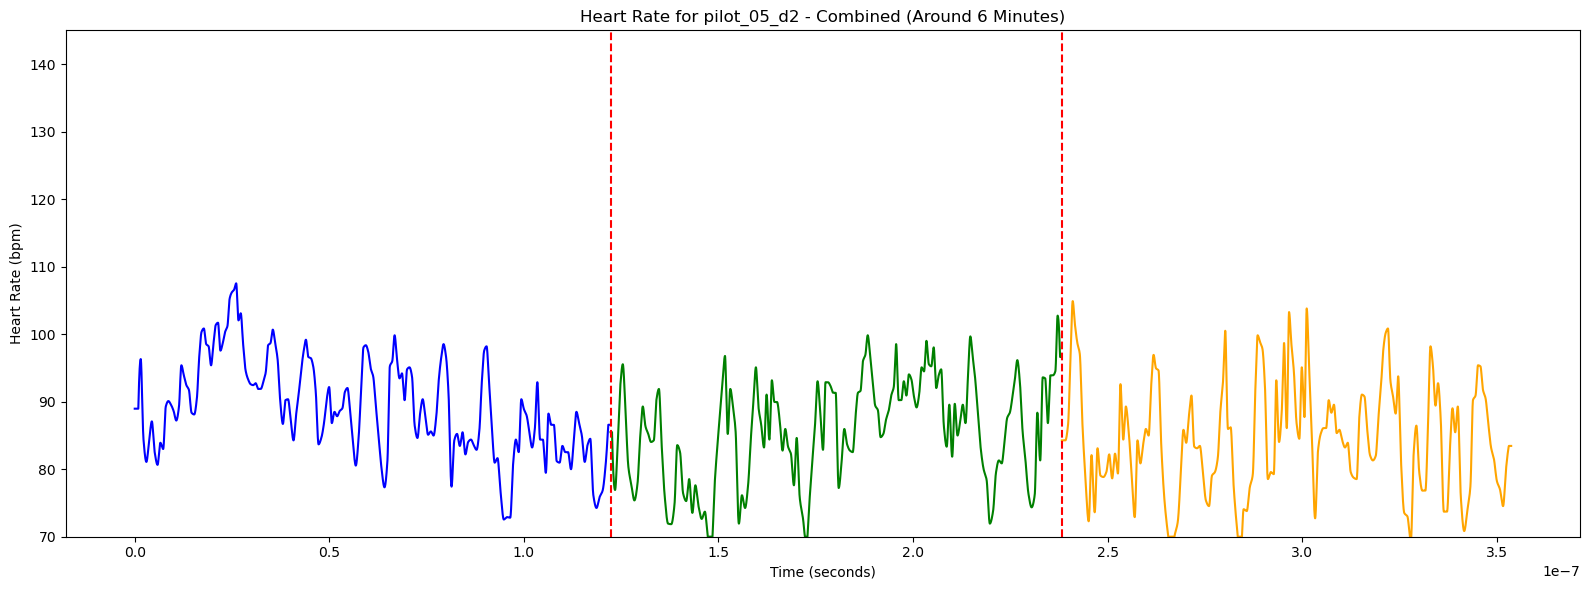

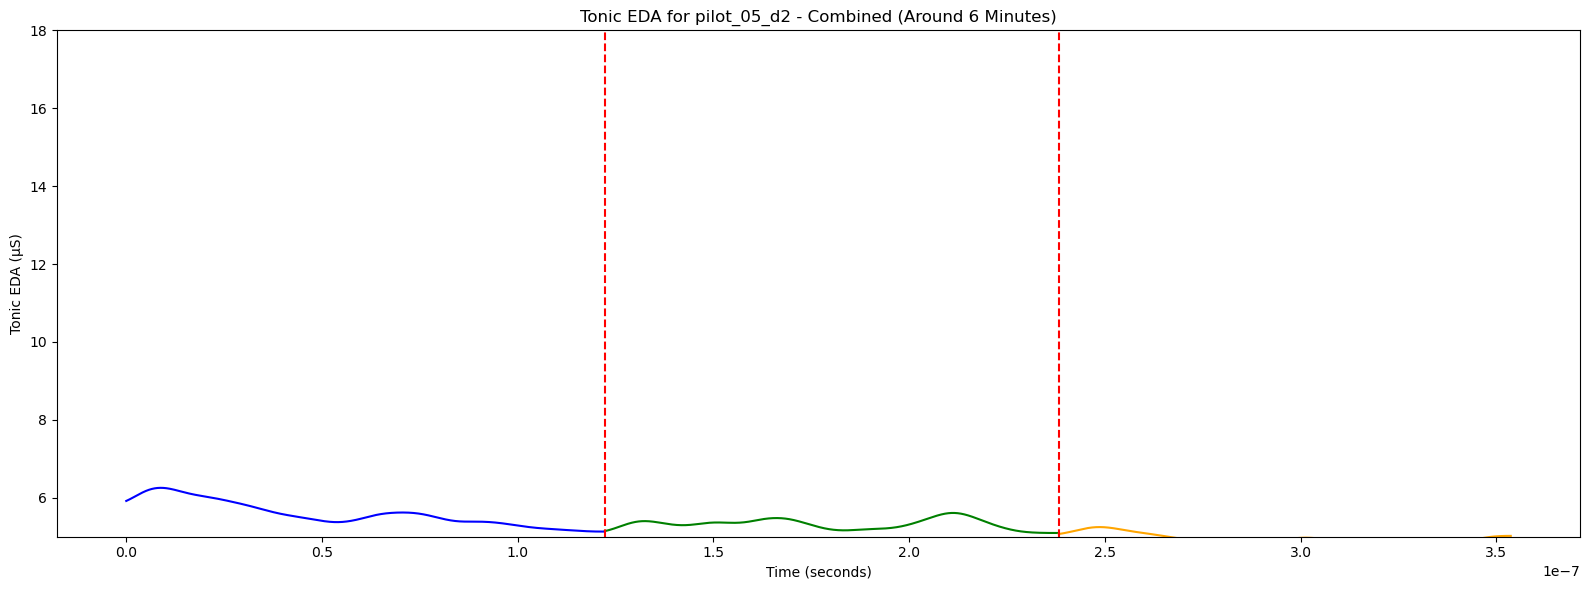

Processing participant: pilot_06_d2
Sorted files: []


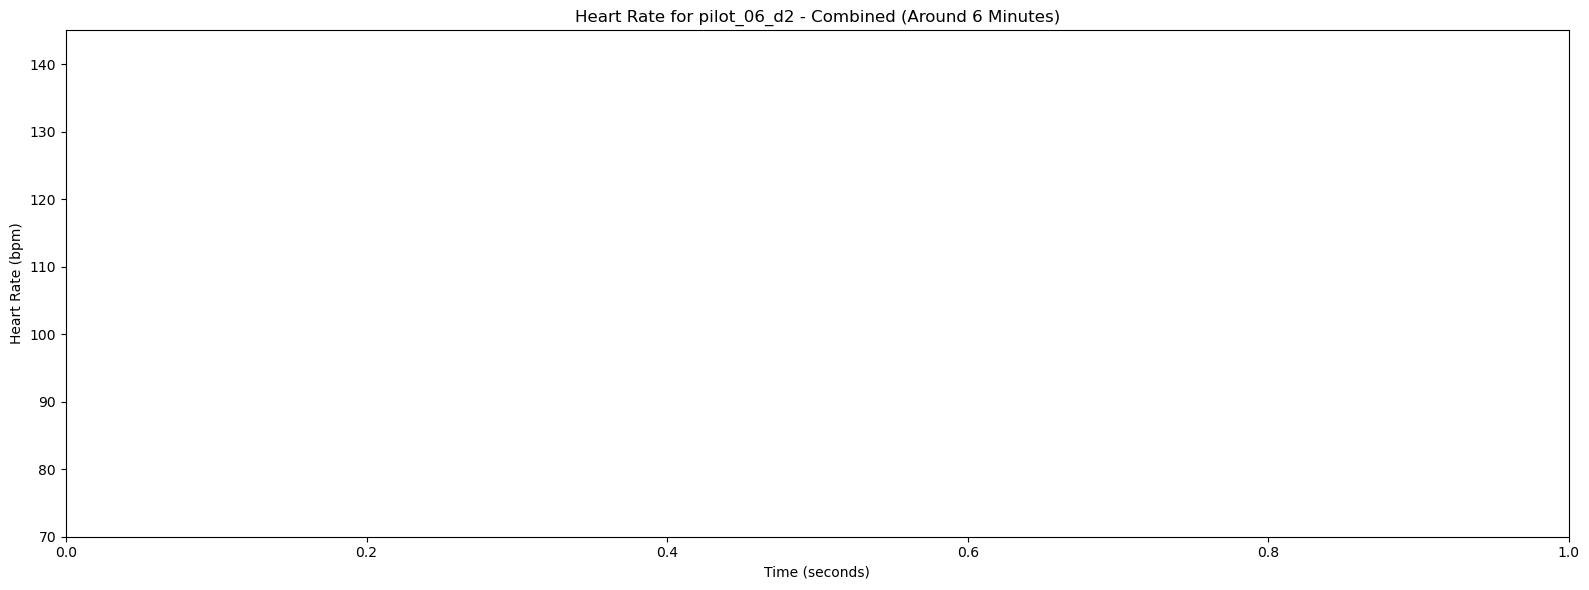

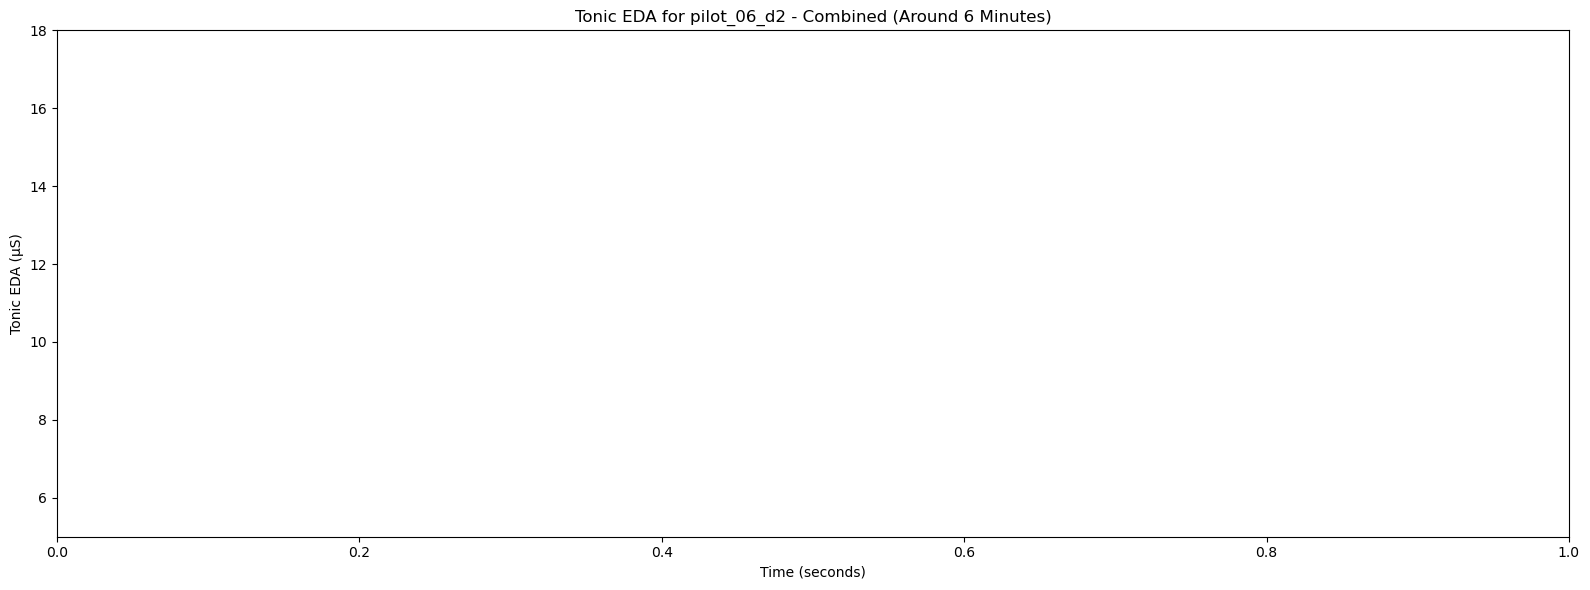

PermissionError: [Errno 13] Permission denied: 'Z:\\Davide_MultimodalLab\\3_DATA_ANALYSIS\\5_PHYSIOLOGY\\summary_results\\summary_heart_rate_tonic_eda.csv'

In [20]:

participant_IDs = ['pilot_01_d2', 'pilot_01_d3', 'pilot_02_d2', 'pilot_02_d3', 'pilot_04_d2', 'pilot_05_d2', 'pilot_06_d2']
output_summary = []

# Define a custom sorting key function
def sort_files(file):
    if 'Speech_Start' in file:
        return 0  # Assign 0 to the first file
    elif 'SUD_1_End' in file:
        return 1  # Assign 1 to the second file
    elif 'SUD_3_Start' in file:
        return 2  # Assign 2 to the last file
    return 3  # In case none of the keywords match, assign a default value

for participant_ID in participant_IDs:  # Loop through all participants
    print(f'Processing participant: {participant_ID}')

    participant_files = []
    conditions = []
    for root, dirs, files in os.walk(input_PLUX):
        for file in files:
            if participant_ID in file and 'PLUX' in file and file.endswith(".csv"):
                print(f'Found file: {file}')
                participant_files.append(os.path.join(root, file))
                condition = file.split('speech_')[1].split('.csv')[0]
                conditions.append(condition)

    


    # Sort files based on the custom order: Speech_Start, SUD_1_End, SUD_3_Start
    files_sorted = sorted(participant_files, key=sort_files)
    print(f'Sorted files: {files_sorted}')

    # Initialize lists to accumulate data across all files for combined plots
    cumulative_time = 0  # Start with 0 for cumulative time
    all_times = []
    all_hr = []
    all_eda = []

    # Initialize variables for summary data
    hr_averages = []
    eda_averages = []
    segment_boundaries = []  # To store the time points where each file ends

    # Loop through sorted files (Speech_Start, SUD_1_End, SUD_3_Start)
    for i, file in enumerate(files_sorted):
        # Extract relevant parts from filename
        fnam = os.path.basename(file)[:-4]
        day_num = fnam.split('_')[2]
        
        print(f"Processing file: {os.path.basename(file)}")
        
        # Load data
        data = pd.read_csv(file)

        ### -------------------- ECG Processing -------------------- ###
        ECG_signal = data['PLUX_ECG1']
        print("Processing ECG signal...")
        
        # Filter the ECG using our custom function with high-pass, low-pass, and notch filters
        ECG_processed = process_ecg(ECG_signal, sampling_rate, 1.5, 40, 50, 30)
        
        
        # Now, detect R-peaks using nk.ecg_peaks() on the cleaned ECG signal with NaNs
        ecg_peaks, r_peak_info = nk.ecg_peaks(ECG_processed, sampling_rate=sampling_rate, method='neurokit', correct_artifacts=True)

        # Continue with R-peaks detection and heart rate calculation
        r_peaks_indices = np.where(ecg_peaks['ECG_R_Peaks'] == 1)[0]
        r_peak_times_in_seconds = r_peaks_indices / sampling_rate

        # Calculate heart rate
        heart_rate = nk.ecg_rate(r_peaks_indices, sampling_rate=sampling_rate, desired_length=len(ECG_processed))

        # Define the acceptable heart rate range
        min_hr = 70
        max_hr = 145

        # Detect heart rate values that fall outside the range
        out_of_range_mask = (heart_rate < min_hr) | (heart_rate > max_hr)

        # Smooth out the outliers using interpolation
        # Interpolate only the outlier values, while leaving the in-range values as they are
        heart_rate_smoothed = pd.Series(heart_rate).copy()  # Copy to preserve original heart rate

        # Apply interpolation to smooth the outliers
        heart_rate_smoothed[out_of_range_mask] = np.interp(
            np.where(out_of_range_mask)[0],  # Positions of outliers
            np.where(~out_of_range_mask)[0],  # Positions of valid heart rate values
            heart_rate[~out_of_range_mask]    # Valid heart rate values
        )

        # Now clamp the smoothed values to ensure they fall within the specified range
        heart_rate_clamped = np.clip(heart_rate_smoothed, min_hr, max_hr)


        # Accumulate heart rate and time data
        time_in_seconds = (data['LSL_Time'] - data['LSL_Time'].iloc[0]) / 1e9
        time_in_seconds += cumulative_time  # Shift time by cumulative time
        all_times.append(time_in_seconds)
        all_hr.append(heart_rate_clamped)

        # Compute average heart rate for this condition and add to summary
        avg_hr = heart_rate_clamped.mean()
        hr_averages.append(avg_hr)

        # Update cumulative time by adding the duration of this file
        cumulative_time += time_in_seconds.iloc[-1] - time_in_seconds.iloc[0]

        # Store the boundary of this segment
        segment_boundaries.append(cumulative_time)

        ### -------------------- EDA Processing -------------------- ###
        EDA_signal = data['PLUX_EDA0']
        print("Processing EDA signal...")
        eda_signals, eda_info = nk.eda_process(EDA_signal, sampling_rate)

        # Extract tonic EDA
        tonic_eda = eda_signals['EDA_Tonic']
        
        # Accumulate tonic EDA and time data
        all_eda.append(tonic_eda)

        # Compute average tonic EDA for this condition and add to summary
        avg_eda = tonic_eda.mean()
        eda_averages.append(avg_eda)

        # Save summary data for this file (participant, day, condition, avg HR, avg EDA)
        output_summary.append({
            'participant_ID': participant_ID,
            'condition': conditions[i],
            'avg_hr': avg_hr,
            'avg_eda': avg_eda
        })

    # After processing all files, plot combined heart rate and EDA over time

    ### PLOT HEART RATE (HR) ###
    plt.figure(figsize=(16, 6))
    color = ['blue', 'green', 'orange']  # Colors for each segment
    
    for i, (times, hr) in enumerate(zip(all_times, all_hr)):
        plt.plot(times, hr, color=color[i], lw=1.5, label=conditions[i])
    
    # Add red dashed vertical lines to separate segments
    for boundary in segment_boundaries[:-1]:  # Skip the last cumulative time as it's the end of the last segment
        plt.axvline(boundary, color='red', linestyle='--', lw=1.5)

    plt.xlabel('Time (seconds)')
    plt.ylabel('Heart Rate (bpm)')
    plt.ylim(70, 145)  # Set the y-axis limits
    plt.title(f'Heart Rate for {participant_ID} - Combined (Around 6 Minutes)')
    #plt.legend()
    plt.tight_layout()
    output_hr_plot = os.path.join(figures_results, f'{participant_ID}_combined_HEART_RATE.png')
    plt.savefig(output_hr_plot, dpi=300)
    plt.show()

   ### PLOT TONIC EDA ###
    plt.figure(figsize=(16, 6))
    for i, (times, eda) in enumerate(zip(all_times, all_eda)):
        plt.plot(times, eda, color=color[i], lw=1.5,  label=conditions[i])

    # Add red dashed vertical lines to separate segments
    for boundary in segment_boundaries[:-1]:  # Skip the last cumulative time as it's the end of the last segment
        plt.axvline(boundary, color='red', linestyle='--', lw=1.5)

    plt.xlabel('Time (seconds)')
    plt.ylabel('Tonic EDA (µS)')
    plt.ylim(5, 18)  # Set the y-axis limits
    plt.title(f'Tonic EDA for {participant_ID} - Combined (Around 6 Minutes)')
    #plt.legend()
    plt.tight_layout()
    output_eda_plot = os.path.join(figures_results, f'{participant_ID}_combined_TONIC_EDA.png')
    plt.savefig(output_eda_plot, dpi=300)
    plt.show()
    
# Save the summary data to a CSV file
summary_df = pd.DataFrame(output_summary)
summary_csv_filepath = os.path.join(summary_results, 'summary_heart_rate_tonic_eda.csv')
summary_df.to_csv(summary_csv_filepath, index=False)

print(f'Summary CSV saved to {summary_csv_filepath}')


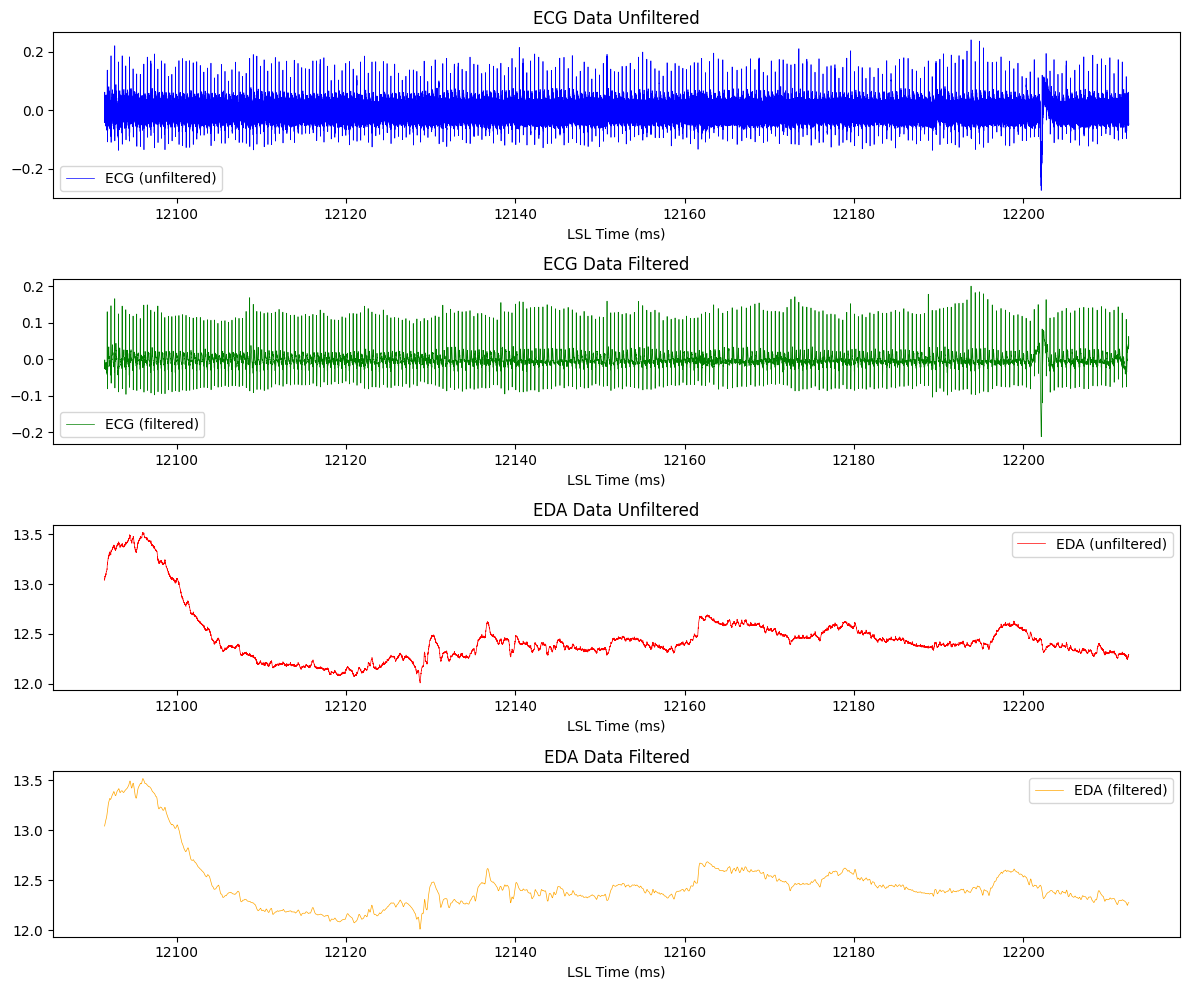

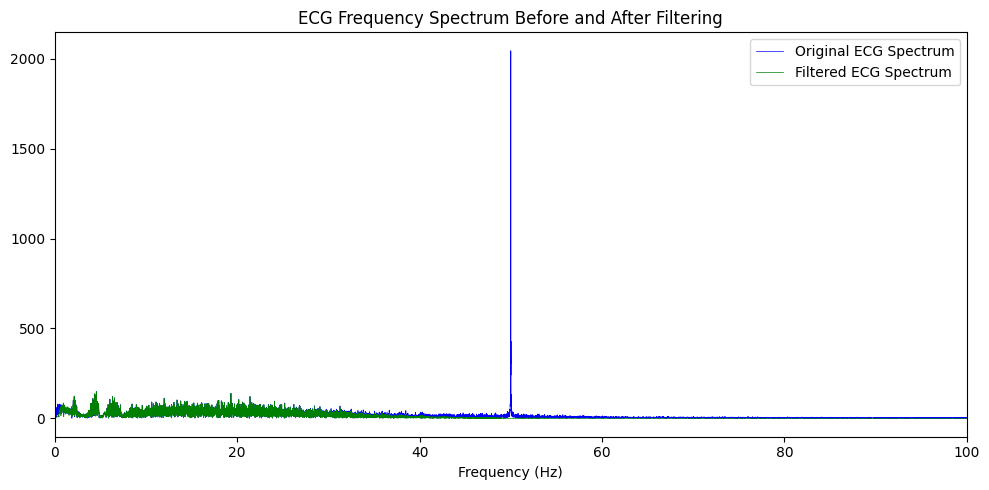

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch
import neurokit2 as nk

# Define filter functions
def butter_filter(signal, cutoff, fs, order=4, filter_type='low'):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype=filter_type, analog=False)
    return filtfilt(b, a, signal)

def notch_filter(signal, fs, notch_freq=50, quality_factor=30):
    b, a = iirnotch(notch_freq / (fs / 2), quality_factor)
    return filtfilt(b, a, signal)

# ECG processing function
def process_ecg(ecg_signal, fs, cutoff_high, cutoff_low, notch_freq, quality_factor):
    high_passed = butter_filter(ecg_signal, cutoff_high, fs, order=4, filter_type='high')
    low_passed = butter_filter(high_passed, cutoff_low, fs, order=4, filter_type='low')
    filtered = notch_filter(low_passed, fs, notch_freq, quality_factor)
    return filtered

# EDA processing function
def process_eda(eda_signal, fs, cutoff_low):
    # Apply low-pass filter to remove noise
    low_passed = butter_filter(eda_signal, cutoff_low, fs, order=4, filter_type='low')
    return low_passed

# Load your PLUX data (assuming it's in a DataFrame)
input_file = r'Z:\Davide_MultimodalLab\2_PREPROCESSING\1_XDF_PROCESSING\data_processed_final\marker_3pairs\pilot_01\day2\pilot_01_d2_speech_lsl_PLUX_Speech_Start_SUD_1_Start.csv'
PLUX_data = pd.read_csv(input_file)
sampling_rate = 1000  # Hz (adjust based on your setup)

# Extract ECG and EDA signals
ECG = PLUX_data['PLUX_ECG1']  # Column index for ECG
EDA = PLUX_data['PLUX_EDA0']   # Column index for EDA

# Process ECG
ECG_processed = process_ecg(ECG, sampling_rate, 0.5, 40, 50, 30)

# Process EDA
EDA_processed = process_eda(EDA, sampling_rate, cutoff_low=5)  # Low-pass with 5 Hz cutoff

# Visualization: ECG and EDA before and after filtering
plt.figure(figsize=(12, 10))

# ECG - Before and After Filtering
plt.subplot(4, 1, 1)
plt.plot(PLUX_data['LSL_Time'], ECG, label='ECG (unfiltered)', color='blue', linewidth=0.5)
plt.legend()
plt.xlabel('LSL Time (ms)')
plt.title('ECG Data Unfiltered')

plt.subplot(4, 1, 2)
plt.plot(PLUX_data['LSL_Time'], ECG_processed, label='ECG (filtered)', color='green', linewidth=0.5)
plt.legend()
plt.xlabel('LSL Time (ms)')
plt.title('ECG Data Filtered')

# EDA - Before and After Filtering
plt.subplot(4, 1, 3)
plt.plot(PLUX_data['LSL_Time'], EDA, label='EDA (unfiltered)', color='red', linewidth=0.5)
plt.legend()
plt.xlabel('LSL Time (ms)')
plt.title('EDA Data Unfiltered')

plt.subplot(4, 1, 4)
plt.plot(PLUX_data['LSL_Time'], EDA_processed, label='EDA (filtered)', color='orange', linewidth=0.5)
plt.legend()
plt.xlabel('LSL Time (ms)')
plt.title('EDA Data Filtered')

plt.tight_layout()
plt.show()

# Optional: Frequency spectrum visualization for ECG
freqs = np.fft.rfftfreq(len(ECG), d=1/sampling_rate)
fft_ecg = np.abs(np.fft.rfft(ECG))
fft_ecg_processed = np.abs(np.fft.rfft(ECG_processed))

plt.figure(figsize=(10, 5))
plt.plot(freqs, fft_ecg, label='Original ECG Spectrum', color='blue', linewidth=0.5)
plt.plot(freqs, fft_ecg_processed, label='Filtered ECG Spectrum', color='green', linewidth=0.5)
plt.xlim(0, 100)
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.title('ECG Frequency Spectrum Before and After Filtering')
plt.tight_layout()
plt.show()

# Create DataFrames for processed signals
ECG_df = pd.DataFrame({'time': np.arange(len(ECG_processed)) / sampling_rate, 'ecg': ECG_processed})
EDA_df = pd.DataFrame({'time': np.arange(len(EDA_processed)) / sampling_rate, 'eda': EDA_processed})

# Save processed data if needed
# ECG_df.to_csv('processed_ecg.csv', index=False)
# EDA_df.to_csv('processed_eda.csv', index=False)
